In [1]:
import os
import joblib
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
def predict_by_features(model, features):
    # Convert input data to a numpy array
    input_data = np.array(features).reshape(1, -1)
    # Make a prediction using the pre-trained model
    prediction = model.predict(input_data)
    # Return the predicted output
    return prediction[0]

In [3]:
def split_image_and_predict(model, input_image_path, block_size):
    # Open the input image
    img=cv2.imread(input_image_path, cv2.IMREAD_UNCHANGED)

    # Get the size of the original image
    height = img.shape[0]
    width = img.shape[1]

    # Calculate the number of rows and columns for the 16x16 grid
    rows = height // block_size
    cols = width // block_size

    # Specify the special color (e.g., red)
    special_color = [0, 0, 1]  # Red: [R, G, B]
    mask = np.zeros(img.shape[:2], dtype="uint8")
    # image_2d_array = np.eye(rows, cols)
    # Loop through each grid cell
    for row in range(rows):
        for col in range(cols):
            # Calculate the coordinates for cropping each cell
            left = col * block_size
            top = row * block_size
            right = left + block_size
            bottom = top + block_size

            # Crop the cell from the original image
            cell_image = img[top:bottom, left:right]
            # cell_image = original_image.crop((left, top, right, bottom))

            features = extract_features(cell_image)
            result = predict_by_features(model, features)
            if result == 1:
                cv2.rectangle(mask, (left, top), (right, bottom), 255, -1)

    return mask, img

In [4]:
def extract_features(image):
    number_of_colors = 10
    clf = KMeans(n_clusters = number_of_colors)
    modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)
    center_colors = clf.cluster_centers_

    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in range(0, len(ordered_colors))]
    l = len(rgb_colors)
    if l < 10:
        for i in range(l, 10):
            rgb_colors.append(rgb_colors[0])
    return rgb_colors

/usr/local/lib/python3.9/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:1

None


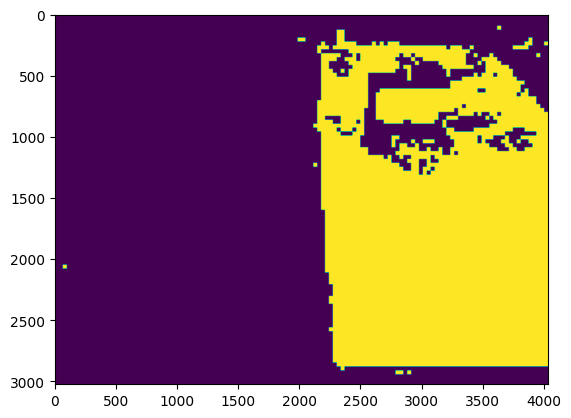

In [5]:

# Load the pre-trained SVM model from the .sav file
model = joblib.load('color_svm.sav')

# Define a function to make predictions using the pre-trained model
def predict(path, img):
    split_tup = os.path.splitext(img)
    if len(split_tup) > 1 and split_tup[len(split_tup)-1] == ".png":
        color_mask, img = split_image_and_predict(model, os.path.join(path, img), 32)
        plt.imshow("mask", color_mask)
        plt.imshow("orig", img)
    else:
        print("The image file is not PNG file")


print(predict("./simple", "IMG_9974.png"))